## Plotting

##### 2022.03.18

In [1]:
!pip install mne
!pip install braindecode
!pip install torch

In [2]:
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import logging

from braindecode.datasets import TUH, TUHAbnormal
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)


plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

##### Loading TUH Abnormal EEG Corpus

This generates a description of the recordings.

In [3]:
TUH_PATH = 'TUH EEG Abnormal dataset/Abnormal'
N_JOBS = 2  # specify the number of jobs for loading and windowing
tuh = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name=None,
    preload=False,
    add_physician_reports=True,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS,  # Mock dataset can't
    # be loaded in parallel
)

Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/058/00005864/s001_2009_09_03/00005864_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/s003_2009_09_03/00004196_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/058/00005851/s001_2009_09_04/00005851_s001_t001.edf...
EDF file detected
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/train/normal/01_tcp_ar/009/00000929/s003_2009_09_04/00000929_s003_t002.edf...
EDF file detected
Setting channel info structure...
Setting channel info structure...
Creating raw.info structure...
Creating raw.info structure...
Extracting EDF parameters from 

/opt/conda/lib/python3.9/site-packages/braindecode/datasets/tuh.py:79: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(file_path, preload=preload)


Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/062/00006240/s001_2009_12_15/00006240_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/062/00006218/s001_2009_12_16/00006218_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/train/abnormal/01_tcp_ar/059/00005931/s002_2009_12_21/00005931_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/normal/01_tcp_ar/062/00006212/s001_2009_12_22/00006212_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters fro

/opt/conda/lib/python3.9/site-packages/braindecode/datasets/tuh.py:79: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(file_path, preload=preload)


Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/train/normal/01_tcp_ar/091/00009165/s001_2012_03_09/00009165_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/train/abnormal/01_tcp_ar/035/00003523/s003_2012_03_12/00003523_s003_t000.edf...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/eval/abnormal/01_tcp_ar/092/00009265/s001_2012_03_09/00009265_s001_t000.edf...
EDF file detected
EDF file detected
Setting channel info structure...
Setting channel info structure...
Creating raw.info structure...
Creating raw.info structure...
Extracting EDF parameters from /work/TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/train/normal/01_tcp_ar/092/00009299/s001_2012_03_12/00009299_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structu

##### Calculate stats

In [4]:
male_norm = tuh.description.query('gender=="M" and pathological==False')
male_abnm = tuh.description.query('gender=="M" and pathological==True')
female_norm = tuh.description.query('gender=="F" and pathological==False')
female_abnm = tuh.description.query('gender=="F" and pathological==True')
n_bins = 21
d_labels = ['Normal', 'Abnormal']

In [5]:
mean_age = tuh.description.groupby(['gender']).mean() # mean of age grouped by gender
std_age = tuh.description.groupby(['gender']).std() # standard deviation of age grouped by gender

mean_age_male = mean_age.loc['M']['age'] # mean of age of male patients
std_age_male = std_age.loc['M']['age'] # standard deviation of age of male patients
n_male = len(male_norm) + len(male_abnm) # overall number of male patients' recordings in the data
p_male_norm = (len(male_norm)/n_male)*100 # % of recordings with normal EEG activity out of male patients' data
p_male_abnm = 100 - p_male_norm # % of recordings with abnormal EEG activity out of male patients' data

mean_age_female = mean_age.loc['F']['age'] # mean of age of female patients
std_age_female = std_age.loc['F']['age'] # standard deviation of age of female patients
n_female = len(female_norm) + len(female_abnm) # overall number of female patients' recordings in the data
p_female_norm = (len(female_norm)/n_female)*100 # % of recordings with normal EEG activity out of female patients' data
p_female_abnm = 100 - p_female_norm # % of recordings with abnormal EEG activity out of female patients' data

p_male = (n_male/(n_male + n_female))*100 # % of male patients' recordings out of all records
p_female = 100 - p_male # % of female patients' recordings out of all records

In [5]:
# Calculate no. of normal/abnormal recordings in the training/eval set

##### Gender/age distribution plot

Text(0, 0.5, 'Count')

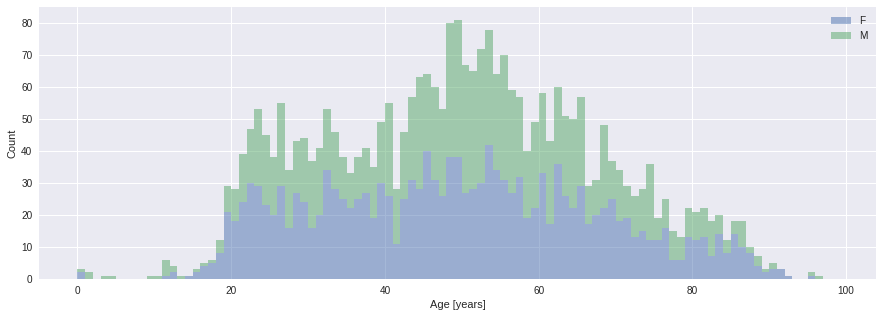

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh.description.gender.unique()
x = [tuh.description.age[tuh.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')

##### Number of sessions per patient

Text(0, 0.5, 'Occurences')

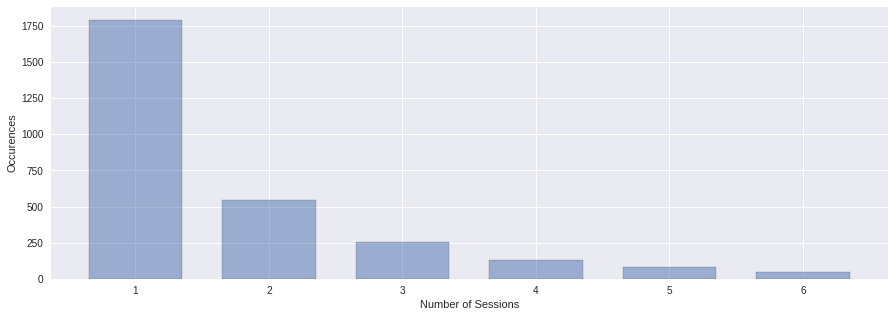

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
x = tuh.description.session
ax.hist(
    x=x,
    bins=np.arange(1,8,1)-0.5,
    alpha=.5,
    ec='black',
    rwidth=.7
    
)
ax.set_xlabel('Number of Sessions')
ax.set_ylabel('Occurences')

##### Number of records per year

In [11]:
tuh.description.year.unique()

array([2009, 2010, 2011, 2012, 2013])

Text(0, 0.5, 'Number of Recordings')

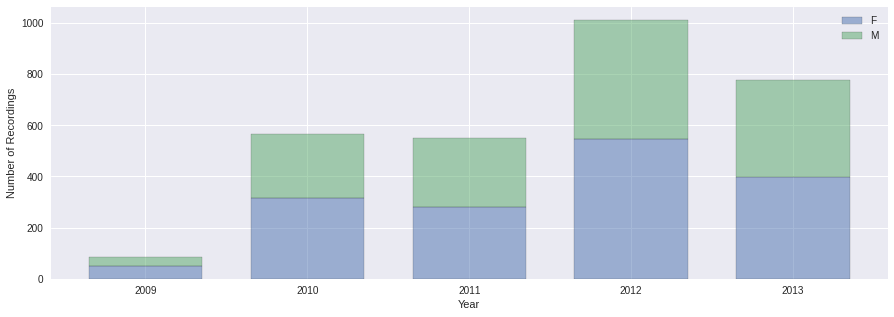

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
x = [tuh.description.year[tuh.description.gender == g] for g in genders]
ax.hist(
    x=x,
    bins=np.arange(2009,2015,1)-0.5,
    stacked=True,
    alpha=.5,
    ec='black',
    rwidth=.7
    
)
ax.legend(genders)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Recordings')

##### Recordings duration

In [13]:
length = []
for d_i, d in enumerate(tuh.datasets):
        length.append(int((d.raw.n_times / d.raw.info['sfreq'])/60))

In [14]:
length[:5]

[23, 50, 19, 19, 50]

Text(0, 0.5, 'Number of Recordings')

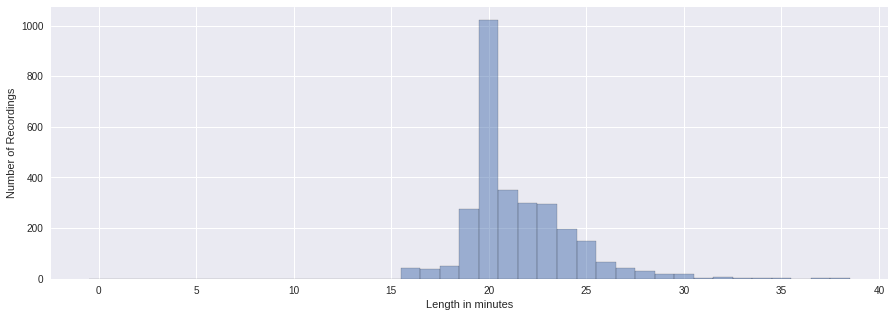

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
x = length
ax.hist(
    x=x,
    bins=np.arange(0,40)-0.5,
    alpha=.5,
    ec='black',
    #rwidth=.7
    
)
ax.set_xlabel('Length in minutes')
ax.set_ylabel('Number of Recordings')

##### Abnormal/Normal Distribution - Population Pyramid

In [17]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 558 kB/s eta 0:00:011


In [19]:
# Stack normal and abnormal records

from chart_studio.plotly import plotly as py
import plotly.graph_objs as go
import plotly.io as pio
#pio.renderers.default='notebook'

# Create age groups (0-10, 10-20, etc.) column
tuh_mod = tuh.description
bins= [0,10,20,30,40,50,60,70,80,90,100]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
age_group = pd.cut(tuh.description['age'], bins=bins, labels=labels, right=False)
tuh_mod['age_group'] = age_group
male = tuh_mod.query('gender=="M"')
female = tuh_mod.query('gender=="F"')

y = list(range(0, 100, 10))
women_bins = female.groupby('age_group').count()
women_bins = np.array(women_bins.path * -1)
men_bins = male.groupby('age_group').count()
men_bins = np.array(men_bins.path)

layout = go.Layout(yaxis=go.layout.YAxis(title='Age'),
                   xaxis=go.layout.XAxis(
                       range=[-400, 400],
                       tickvals=[-400, -300, -200, -100, 0, 100, 200, 300, 400],
                       ticktext=[400, 300, 200, 100, 0, 100, 200, 300, 400],
                       title='Number'),
                   barmode='overlay',
                   bargap=0.1)

data = [go.Bar(y=y,
               x=men_bins,
               orientation='h',
               name='Men',
               text=men_bins.astype('int'),
               hoverinfo='text',
               marker=dict(color='powderblue')
               ),
        go.Bar(y=y,
               x=women_bins,
               orientation='h',
               name='Women',
               text=-1*women_bins.astype('int'),
               hoverinfo='text',
               marker=dict(color='seagreen')
               )]

fig = go.Figure(data=data,layout=layout)
fig.show()

## Preprocessing

In [ ]:
!pip install mne
!pip install braindecode
!pip install torch

In [ ]:
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import logging

from braindecode.datasets import TUH, TUHAbnormal
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)


plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

In [ ]:
TUH_PATH = 'TUH EEG Abnormal dataset/Abnormal'
N_JOBS = 2  # specify the number of jobs for loading and windowing
tuh = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name=None,
    preload=False,
    add_physician_reports=True,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS,  # Mock dataset can't
    # be loaded in parallel
)

##### 1. Selecting a subset of 21 electrode positions following the international 10-20 placement
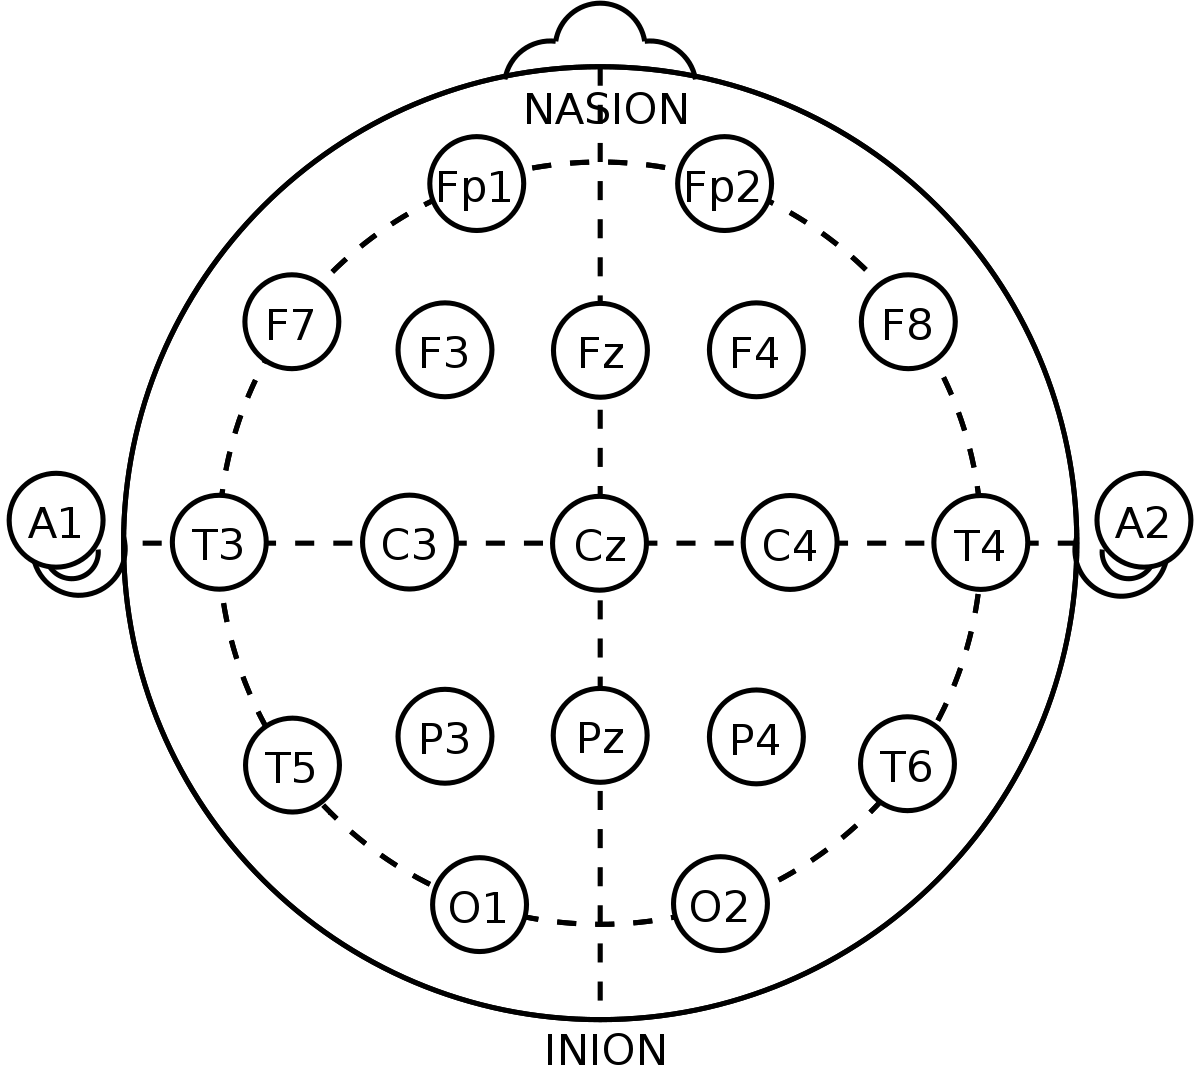

In [20]:
# We will discard all recordings that have an incomplete channel
# configuration (wrt the channels that we are interested in, i.e. the 21
# channels of the international 10-20-placement). The dataset is subdivided into
# recordings with 'le' and 'ar' reference which we will have to consider. Data
# is not loaded here.

short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
le_ch_names = sorted([
    'EEG A1-LE', 'EEG A2-LE',
    'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
    'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
    'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
    'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}
le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    le_ch_names, short_ch_names)}
ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}


def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']


tuh_preproc = select_by_channels(tuh, ch_mapping)

In [23]:
len(tuh_preproc.description)
# meaning every recording had the 21 channels available

2993

In [27]:
# Adding channel positions for each recording

tuh_extended = tuh.description
channel_names = [] # np.empty(shape=(2993,))
for i in range(len(tuh.datasets)): 
    channel_names.append(tuh.datasets[i].raw.ch_names)
tuh_extended['channels'] = channel_names

In [28]:
tuh_extended.head()

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological,channels
0,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-..."
1,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-..."
2,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/t...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-..."
3,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-..."
4,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/t...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-..."


##### 2. Discard the first 60 seconds of every recording & use a maximum of 20 minutes

In [29]:
# for comparison, create column with the length of each recording

length = [] # np.empty(shape=(2993,))
for i in range(len(tuh.datasets)): 
    length.append(tuh.datasets[i].raw.n_times / tuh.datasets[i].raw.info['sfreq'])
tuh_extended['length'] = length

tuh_extended.head(5)

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological,channels,length
0,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-...",1402.0
1,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-...",3023.0
2,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/t...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-...",1187.0
3,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-...",1147.0
4,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/t...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-...",3009.0


In [34]:
# based on: https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.crop

def select_by_duration(ds, tmin=0, tmax=None, include_tmax=True):
    if tmax is None:
        tmax = np.inf
    # determine length of the recordings and select based on tmin and tmax
    split_ids = []
    for d_i, d in enumerate(ds.datasets):
        duration = d.raw.n_times / d.raw.info['sfreq']
        if tmin < duration: # since if we crop 1min, there would be nothing left
            split_ids.append(d_i)
            tmax = min((d.raw.n_times - 1) / d.raw.info['sfreq'], tmax)
            d.raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)
    return ds.split(split_ids)['0']

tmin = 1 * 60
# because we crop the first 60 seconds of each recording, this is how we keep a maximum 20 minutes of data
tmax = 21 * 60


# tuh_preproc = select_by_duration(tuh, tmin, tmax)

In [31]:
select_by_duration(tuh_preproc, tmin, tmax)

In [33]:
# Adding the cropped length of each recording to the DataFrame

tuh_extended = tuh_preproc.description
length = [] # np.empty(shape=(2993,))
for i in range(len(tuh_preproc.datasets)): 
    length.append(tuh_preproc.datasets[i].raw.n_times / tuh_preproc.datasets[i].raw.info['sfreq'])
tuh_extended['length'] = length

tuh_extended.head(5)

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological,length
0,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False,1140.004
1,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False,1140.004
2,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/t...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False,1127.000
3,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/e...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False,1087.000
4,TUH EEG Abnormal dataset/Abnormal/v2.0.0/edf/t...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False,1087.000


##### Downsample recordings to 100 Hz and clip at $\pm800\mu Hz$
https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.resample

In [9]:
tuh.datasets[0].raw.info['sfreq']

250.0

In [ ]:
# downsampling to 100 Hz
#needs to be done in batches
sfreq = 100


for d_i, d in enumerate(tuh.datasets):
    d.raw.resample(sfreq)
        